The aim of this experiment is to check whether non-anti LGBTQ contents contain hope speech. 

# General Functions

In [ ]:
# We set hope_speech = 1; non_hope_speech = 0
def label_col(row):
  if row['labels'] == 'Non_hope_speech;;':
    return 0
  elif row['labels'] == 'Hope_speech;;':
    return 1
  elif row['labels'] == 'Non_hope_speech;':
    return 0
  elif row['labels'] == 'Hope_speech;':
    return 1
  elif row['labels'] == 'Non_hope_speech':
    return 0
  elif row['labels'] == 'Hope_speech':
    return 1

In [ ]:
# We map Non-anti-LGBT+ content to 1, i.e., hope_speech and Homophobic & Transphobic to 0, i.e., non_hope_speech
def label_col_Homo(row):
  if row['labels'] == 'Non-anti-LGBT+ content':
    return 1
  elif row['labels'] == 'Homophobic':
    return 0
  elif row['labels'] == 'Transphobic':
    return 0

In [ ]:
# Returns the F1 score computed on the predictions
def f1_score_func(preds, labels):
    preds_flat=np.argmax(preds, axis=1).flatten()
    labels_flat=labels.flatten()
    return f1_score(labels_flat, preds_flat, average='weighted')
    
# Returns the precision, accuracy and recall score computed on the predictions
def prec_func(preds, labels):
    preds_flat=np.argmax(preds, axis=1).flatten()
    labels_flat=labels.flatten()
    return precision_score(labels_flat, preds_flat, average='weighted')

def recall_func(preds, labels):
    preds_flat=np.argmax(preds, axis=1).flatten()
    labels_flat=labels.flatten()
    return recall_score(labels_flat, preds_flat, average='weighted')

def acc_func(preds, labels):
    preds_flat=np.argmax(preds, axis=1).flatten()
    labels_flat=labels.flatten()
    return accuracy_score(labels_flat, preds_flat)

In [ ]:
# Evaluates the model using the validation set
def evaluate(model, dataloader_val):
  model.eval()
  loss_val_total = 0
  predictions, true_vals = [], []

  for batch in dataloader_val:
      batch = tuple(b.to(device) for b in batch)
      inputs = {'input_ids': batch[0],
        'attention_mask': batch[1],
        'labels': batch[2],
        }

      with torch.no_grad():
          outputs = model(**inputs)

      loss = outputs[0]
      logits = outputs[1]
      loss_val_total += loss.item()

      logits = logits.detach().cpu().numpy()
      label_ids = inputs['labels'].cpu().numpy()
      predictions.append(logits)
      true_vals.append(label_ids)

  loss_val_avg = loss_val_total / len(dataloader_val)

  predictions = np.concatenate(predictions, axis=0)
  true_vals = np.concatenate(true_vals, axis=0)

  return loss_val_avg, predictions, true_vals

In [ ]:
# Evaluates the model using the validation set
def predict(dataset_test):
    predictions = []
    probas = []
    for row in dataset_test:
      row = tuple(r.to(device) for r in row)
      inputs = {'input_ids': row[0],
        'attention_mask': row[1]
        }

      with torch.no_grad():
          outputs = model(**inputs)

      logits = outputs[0]
      probas.append(F.softmax(logits, dim=-1))
      logits = logits.detach().cpu().numpy()
      predictions.append(logits)

    return probas,predictions

Arianna's code: only edit to the number of epochs set to 3 (motivated from literature & to speed up this code development phase  

In [ ]:
def trainBERT(data):
  scores = []
  # Split dataset in traning and validation(test)
  X_train, X_val, Y_train, Y_val = train_test_split(
      data.index.values,
      data.labels.values,
      test_size=0.10,
      random_state=17,
      stratify=data.labels.values
  )
  # Check datasets composition
  data['data_type'] = ['not_set'] * data.shape[0]
  data.loc[X_train, 'data_type'] = 'train'
  data.loc[X_val, 'data_type'] = 'val'
  print("[print in trainBERT] -- Data Composition ")
  print(data.groupby(['labels', 'data_type']).count())
  print("[print in trainBERT] -- Len Train "+str(len(data)))
  data = data.dropna()
  print("[print in trainBERT] -- Len Train after dropping NaN "+str(len(data)))
  # Encode training dataset using the tokenizer
  encoded_data_train = tokenizer.batch_encode_plus(
      data[data.data_type == 'train'].text.values,
      add_special_tokens=True,
      return_attention_mask=True, 
      pad_to_max_length=True,
      max_length=256,
      return_tensors='pt'
  )
  # Encode validation dataset using the tokenizer
  encoded_data_val = tokenizer.batch_encode_plus(
      data[data.data_type == 'val'].text.values,
      add_special_tokens=True,
      return_attention_mask=True,  
      pad_to_max_length=True,
      max_length=256,
      return_tensors='pt'
  )
  # Extract IDs, attention masks and labels from training dataset
  input_ids_train = encoded_data_train['input_ids']
  attention_masks_train = encoded_data_train['attention_mask']
  labels_train = torch.tensor(data[data.data_type == 'train'].labels.values)
  # Extract IDs, attention masks and labels from validation dataset
  input_ids_val = encoded_data_val['input_ids']
  attention_masks_val = encoded_data_val['attention_mask']
  labels_val = torch.tensor(data[data.data_type == 'val'].labels.values)
  # Create train and validation dataset from extracted features
  dataset_train = TensorDataset(input_ids_train, attention_masks_train, labels_train)
  dataset_val = TensorDataset(input_ids_val, attention_masks_val, labels_val)

  # Define the size of each batch
  batch_size = 16

  # Load training dataset
  dataloader_train= DataLoader(
      dataset_train,
      sampler=RandomSampler(dataset_train),
      batch_size=batch_size)

  # Load valuation dataset
  dataloader_val= DataLoader(
      dataset_val,
      sampler=RandomSampler(dataset_val),
      batch_size=batch_size)

  # Load pre-trained BERT model
  model = BertForSequenceClassification.from_pretrained("bert-base-uncased",
                                                        num_labels = 2,
                                                        output_attentions = False,
                                                        output_hidden_states = False)

  model.to(device)  

  # Define model optimizer -> Adam
  optimizer = AdamW(
      model.parameters(),
      lr = 1e-5, 
      eps=1e-8
  )

  # Define model scheduler
  epochs = 4
  scheduler = get_linear_schedule_with_warmup(optimizer,
                                              num_warmup_steps=0,
                                              num_training_steps=len(dataloader_train)*epochs)
  # Define random seeds
  seed_val = 17
  random.seed(seed_val)
  np.random.seed(seed_val)
  torch.manual_seed(seed_val)
  torch.cuda.manual_seed_all(seed_val)
  
  for epoch in tqdm(range(1, epochs + 1)):

      model.train()  # model is training

      loss_train_total = 0

      progress_bar = tqdm(dataloader_train, desc='Epoch {:1d}'.format(epoch), leave=False, disable=False)
      for batch in progress_bar:
          model.zero_grad()
          batch = tuple(b.to(device) for b in batch)
          inputs = {'input_ids': batch[0],
                    'attention_mask': batch[1],
                    'labels': batch[2]}
          
          outputs = model(**inputs)

          loss = outputs[0]
          loss_train_total += loss.item()
          loss.backward()  # to backpropagate

          torch.nn.utils.clip_grad_norm_(model.parameters(),
                                        1.0)  # prevents the gradient from being too small or too big

          optimizer.step()
          scheduler.step()
          progress_bar.set_postfix({'training_loss': '{:.3f}'.format(loss.item() / len(batch))})

      
      torch.save(model, path)
      tqdm.write(f'\nEpoch {epoch}/{epochs}')

      loss_train_avg = loss_train_total / len(dataloader_train)
      tqdm.write(f'Training loss: {loss_train_avg}')  # make sure that model is still training

      val_loss, predictions, true_vals = evaluate(model,dataloader_val)  # to check overtraining (or overfitting)
      val_f1 = f1_score_func(predictions, true_vals)
      val_prec = prec_func(predictions, true_vals)
      val_recall = recall_func(predictions, true_vals)
      val_acc = acc_func(predictions, true_vals)

      scores.append(val_f1)

      tqdm.write(f'Validation loss: {val_loss}')
      tqdm.write(f'F1 Score(weighted) : {val_f1}')
      tqdm.write(f'Prec Score(weighted) : {val_prec}')
      tqdm.write(f'Recall Score(weighted) : {val_recall}')
      tqdm.write(f'Acc Score : {val_acc}')
  score = max(scores)
  return model,score 

Arianna's code: only addition, here we save in addition to the prediction, the probabilities returned for the class 1, i.e., hope_speech

In [ ]:
def predOnTestData(data_test):
  # Encode validation dataset using the tokenizer
  encoded_data_test = tokenizer.batch_encode_plus(
      data_test.text.values,
      add_special_tokens=True,
      return_attention_mask=True,  
      pad_to_max_length=True,
      max_length=256,
      return_tensors='pt'
  )

  # Extract IDs, attention masks and labels from validation dataset
  input_ids_test = encoded_data_test['input_ids']
  attention_masks_test = encoded_data_test['attention_mask']
  dataset_test = TensorDataset(input_ids_test, attention_masks_test)
  dataloader_test = DataLoader(dataset_test)
  
  # Predict values for test dataset
  probas,predictions = predict(dataloader_test)
  results = []
  for i, prediction in enumerate(predictions):
    predicted = np.argmax(prediction, axis=1)[0]
    results.append(predicted)
  pred = []
  for prediction in results:
    pred.append(prediction)
  data_test['pred'] = pred
  probs = []
  # We save the proba for the label 1, i.e., hope-speech 
  for pro in probas:
      probs.append(pro[0].cpu().numpy()[1]) 
  data_test['probs'] = probs
  return data_test 

In [ ]:
def findTopK(data_test, k):
  while len(data_test) > k: 
    # Sort the poolData w.r.t. proba of label 1 
    sorted_data_test = data_test.sort_values(by='probs', ascending=False)
    data_test = data_test.sort_values(by='probs', ascending=False)
    # Keep only the top-k
    sorted_data_test = sorted_data_test[:k]
    # Dropping from the poolData the top-k 
    data_test = data_test[k:] #data_test = data_test.drop(index=list(sorted_data_test.index))
    print("[print in findTopK] -- Len poolData after removing topK "+str(len(data_test)))
    # Resetting the index of the two subsets 
    sorted_data_test = sorted_data_test.reset_index()
    sorted_data_test=sorted_data_test.drop(['index'], 1)  
    sorted_data_test=sorted_data_test.drop(['pred'], 1) 
    sorted_data_test=sorted_data_test.drop(['probs'], 1) 
    data_test = data_test.reset_index()
    data_test=data_test.drop(['index'], 1) 
    data_test=data_test.drop(['pred'], 1) 
    data_test=data_test.drop(['probs'], 1) 
    print("[print in findTopK] -- Print topK")
    print(sorted_data_test)
    print("[print in findTopK] -- Print remaining poolData")
    print(data_test)
    # Returning the two subsets 
    return sorted_data_test,data_test 

# Requirements & Imports

In [ ]:
!pip install transformers
!pip install bert-tensorflow

In [ ]:
import tensorflow as tf
import torch
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm

from transformers import AutoTokenizer, AutoModel
from transformers import BertTokenizer, BertForSequenceClassification
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
import torch.nn.functional as F

from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
from transformers import BertForSequenceClassification
from transformers import AdamW, get_linear_schedule_with_warmup
import random
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score
from sklearn.metrics import classification_report

In [ ]:
from google.colab import drive
drive.mount('/content/drive') 

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
directory = '/content/drive/My Drive/Colab Notebooks/LT-EDI_2022/'

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

# Model trained on train + dev of Hope 2022

## Prep. Data from 'Hope'

Upload Data Hope - Training 

In [ ]:
dataTrain = pd.read_csv("Hope_ENG_train.csv", header=None)
dataDev = pd.read_csv("Hope_ENG_dev.csv", header=None)
#dataTrain = pd.read_csv(directory+"Data_Hope_2022/Hope_ENG_train.csv", header=None)
#dataDev = pd.read_csv(directory+"Data_Hope_2022/Hope_ENG_dev.csv", header=None)
data = pd.concat([dataTrain,dataDev])#,dataTest])
data = data.dropna()
data = data.rename(columns={1: "labels"})
data = data.rename(columns={0: 'text'})
data

,text,labels
0,these tiktoks radiate gay chaotic energy and i...,Non_hope_speech
1,@Champions Again He got killed for using false...,Non_hope_speech
2,It's not that all lives don't matter,Non_hope_speech
3,Is it really that difficult to understand? Bla...,Non_hope_speech
4,Whenever we say black isn't that racists? Why...,Non_hope_speech
...,...,...
2836,Such fake sentiment. .,Non_hope_speech
2837,@A G black lives arent undervalued compared to...,Non_hope_speech
2838,People who pulled it down can and will be arre...,Non_hope_speech
2839,@Aaron Castellanos It will be a two hour movie...,Non_hope_speech


In [ ]:
data.labels.value_counts()

Non_hope_speech    23347
Hope_speech         2234
Name: labels, dtype: int64

In [ ]:
data['labels'] = data.apply(lambda row: label_col(row), axis=1)
data

,text,labels
0,these tiktoks radiate gay chaotic energy and i...,0
1,@Champions Again He got killed for using false...,0
2,It's not that all lives don't matter,0
3,Is it really that difficult to understand? Bla...,0
4,Whenever we say black isn't that racists? Why...,0
...,...,...
2836,Such fake sentiment. .,0
2837,@A G black lives arent undervalued compared to...,0
2838,People who pulled it down can and will be arre...,0
2839,@Aaron Castellanos It will be a two hour movie...,0


## Train

In [ ]:
# Define processor type for torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive') 
model_save_name = 'hope2022_lt.pt'
path = F"/content/gdrive/My Drive/{model_save_name}" 

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
model,current_score = trainBERT(data)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


[print in trainBERT] -- Data Composition 
                   text
labels data_type       
0      train      20538
       val         2809
1      train       1965
       val          269
[print in trainBERT] -- Len Train 25581
[print in trainBERT] -- Len Train after dropping NaN 25581


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2257: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


Downloading:   0%|          | 0.00/420M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/1407 [00:00<?, ?it/s]


Epoch 1/4
Training loss: 0.21118402593704927
Validation loss: 0.18931938892645386
F1 Score(weighted) : 0.9245639413728389
Prec Score(weighted) : 0.9259531060270569
Recall Score(weighted) : 0.9233268356075374
Acc Score : 0.9233268356075374


Epoch 2:   0%|          | 0/1407 [00:00<?, ?it/s]


Epoch 2/4
Training loss: 0.15608935020420522
Validation loss: 0.19714603257495814
F1 Score(weighted) : 0.9293923788892829
Prec Score(weighted) : 0.9281338839117544
Recall Score(weighted) : 0.935672514619883
Acc Score : 0.935672514619883


Epoch 3:   0%|          | 0/1407 [00:00<?, ?it/s]


Epoch 3/4
Training loss: 0.12024407286753623
Validation loss: 0.22728326659615833
F1 Score(weighted) : 0.9292582809896605
Prec Score(weighted) : 0.9273759263897908
Recall Score(weighted) : 0.9343729694606887
Acc Score : 0.9343729694606887


Epoch 4:   0%|          | 0/1407 [00:00<?, ?it/s]


Epoch 4/4
Training loss: 0.09172990047626062
Validation loss: 0.2603273001527221
F1 Score(weighted) : 0.9283354808316328
Prec Score(weighted) : 0.9270995804270397
Recall Score(weighted) : 0.9298245614035088
Acc Score : 0.9298245614035088


In [ ]:
current_score

0.9293923788892829

In [ ]:
path = "/content/gdrive/My Drive/hope2022_lt.pt" 
model = torch.load(path)
model.to(device)  
model 

## Test of Hope Base Model on Test 'Hope' 2021 (labeled!) 

In [ ]:
drive.mount('/content/drive') 

In [ ]:
data_test = pd.read_csv("english_hope_test.csv", header=0, sep=';')
#data_test = pd.read_csv(directory+"Data_Hope_2021/english_hope_test.csv", header=0, sep=';')
data_test = data_test.rename(columns={'label': 'labels'})
data_test = data_test[['text','labels']]
data_test = data_test[data_test['labels'] != 'not-English']
data_test = data_test.dropna()
data_test

,text,labels
0,What do you mean by the word sniped?,Non_hope_speech
1,I love this video!! I’m bisexual and it’s just...,Hope_speech
2,ya the irony but then i don't want to come off...,Non_hope_speech
3,A PERSON'S CHARACTER MATTERS. PERIOD!!,Non_hope_speech
4,@Blaster of Gasters,Non_hope_speech
...,...,...
2841,+Ashrenneemakeup I think it's all a deliberate...,Non_hope_speech
2842,Sheriff David Clarke. This guy is amazing.,Non_hope_speech
2843,Abandorn Hope Situation,Non_hope_speech
2844,Sheriff Clarke you are a person of such strong...,Non_hope_speech


In [ ]:
data_test = predOnTestData(data_test)

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2257: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [ ]:
preds = data_test['pred']

In [ ]:
data_test.labels.value_counts()

Non_hope_speech    2593
Hope_speech         250
Name: labels, dtype: int64

In [ ]:
def label_col (row):
  if row['labels'] == 'Non_hope_speech':
    return 0
  elif row['labels'] == 'Hope_speech':
    return 1

In [ ]:
data_test['labels'] = data_test.apply(lambda row: label_col(row), axis=1)

In [ ]:
data_test.labels.value_counts()

0    2593
1     250
Name: labels, dtype: int64

In [ ]:
data_test['pred'].value_counts()

0    2601
1     242
Name: pred, dtype: int64

In [ ]:
y_p = preds
y_e = data_test[["labels"]].to_numpy()
print(classification_report(y_e, y_p, labels=[0,1]))

              precision    recall  f1-score   support

           0       0.96      0.96      0.96      2593
           1       0.62      0.60      0.61       250

    accuracy                           0.93      2843
   macro avg       0.79      0.78      0.79      2843
weighted avg       0.93      0.93      0.93      2843



# Final Hope model on train + dev Hope 2022 + test 2021 

## Prep. Data from * 'Hope'

Upload Data Hope - Training 

In [ ]:
#dataTrain = pd.read_csv(directory+"Data_Hope_2022/Hope_ENG_train.csv", header=None)
#dataDev = pd.read_csv(directory+"Data_Hope_2022/Hope_ENG_dev.csv", header=None)
#dataTest = pd.read_csv(directory+"Data_Hope_2021/english_hope_test.csv", header=0, sep=';')
dataTrain = pd.read_csv("Hope_ENG_train.csv", header=None)
dataDev = pd.read_csv("Hope_ENG_dev.csv", header=None)
dataTest = pd.read_csv("english_hope_test.csv", header=0, sep=';')
dataTest = dataTest.rename(columns={'label': 1})
dataTest = dataTest.rename(columns={'text': 0})
dataTest = dataTest[[0,1]]
dataTest = dataTest[dataTest[1] != 'not-English']
data = pd.concat([dataTrain,dataDev,dataTest])
data = data.dropna()
data = data.rename(columns={1: "labels"})
data = data.rename(columns={0: 'text'})
data

,text,labels
0,these tiktoks radiate gay chaotic energy and i...,Non_hope_speech
1,@Champions Again He got killed for using false...,Non_hope_speech
2,It's not that all lives don't matter,Non_hope_speech
3,Is it really that difficult to understand? Bla...,Non_hope_speech
4,Whenever we say black isn't that racists? Why...,Non_hope_speech
...,...,...
2841,+Ashrenneemakeup I think it's all a deliberate...,Non_hope_speech
2842,Sheriff David Clarke. This guy is amazing.,Non_hope_speech
2843,Abandorn Hope Situation,Non_hope_speech
2844,Sheriff Clarke you are a person of such strong...,Non_hope_speech


In [ ]:
data.labels.value_counts()

Non_hope_speech    25940
Hope_speech         2484
Name: labels, dtype: int64

In [ ]:
data['labels'] = data.apply(lambda row: label_col(row), axis=1)
data

,text,labels
0,these tiktoks radiate gay chaotic energy and i...,0
1,@Champions Again He got killed for using false...,0
2,It's not that all lives don't matter,0
3,Is it really that difficult to understand? Bla...,0
4,Whenever we say black isn't that racists? Why...,0
...,...,...
2841,+Ashrenneemakeup I think it's all a deliberate...,0
2842,Sheriff David Clarke. This guy is amazing.,0
2843,Abandorn Hope Situation,0
2844,Sheriff Clarke you are a person of such strong...,0


## Train

In [ ]:
# Define processor type for torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive') 
model_save_name = 'hope2022_lt.pt'
path = F"/content/gdrive/My Drive/{model_save_name}" 

Mounted at /content/gdrive


In [ ]:
model,current_score = trainBERT(data)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


[print in trainBERT] -- Data Composition 
                   text
labels data_type       
0      train      22007
       val         3933
1      train       2103
       val          381
[print in trainBERT] -- Len Train 28424
[print in trainBERT] -- Len Train after dropping NaN 28424


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2257: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


Downloading:   0%|          | 0.00/420M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/1507 [00:00<?, ?it/s]


Epoch 1/4
Training loss: 0.2098001472268182
Validation loss: 0.17550260266978984
F1 Score(weighted) : 0.9305360552531358
Prec Score(weighted) : 0.9289343664789776
Recall Score(weighted) : 0.9327770050996754
Acc Score : 0.9327770050996754


Epoch 2:   0%|          | 0/1507 [00:00<?, ?it/s]


Epoch 2/4
Training loss: 0.15287559834839165
Validation loss: 0.19646053004630462
F1 Score(weighted) : 0.9283372670313877
Prec Score(weighted) : 0.928012377754997
Recall Score(weighted) : 0.9357904496986555
Acc Score : 0.9357904496986555


Epoch 3:   0%|          | 0/1507 [00:00<?, ?it/s]


Epoch 3/4
Training loss: 0.11435210526843297
Validation loss: 0.22957295824135482
F1 Score(weighted) : 0.9306434916102762
Prec Score(weighted) : 0.9287909095569886
Recall Score(weighted) : 0.9337042188224386
Acc Score : 0.9337042188224386


Epoch 4:   0%|          | 0/1507 [00:00<?, ?it/s]


Epoch 4/4
Training loss: 0.08550283200437835
Validation loss: 0.26777778176064776
F1 Score(weighted) : 0.9295587903623993
Prec Score(weighted) : 0.928273960369557
Recall Score(weighted) : 0.93115438108484
Acc Score : 0.93115438108484


In [ ]:
current_score

0.9306434916102762



```
current_score = 0.9306434916102762

```


In [ ]:
current_score = 0.9306434916102762

In [ ]:
# Define processor type for torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

drive.mount('/content/gdrive') 
path = "/content/gdrive/My Drive/hope2022_lt.pt" 
model = torch.load(path)
model.to(device)  
model 

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element


# Active Learning Model

## Theory

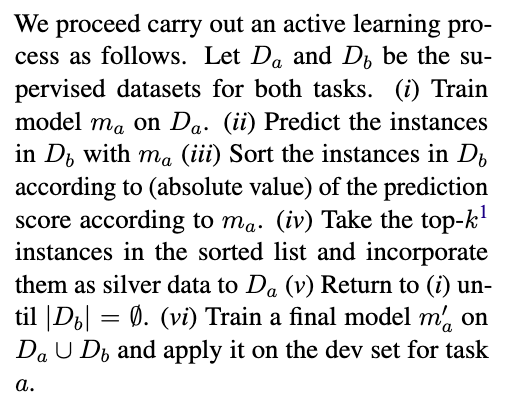

SAMPLING

This approach is used when we have a large dataset.
In this approach, we split our dataset into three parts: Training Set; Test Set; Unlabeled Pool(ironical) [5%; 25%, 70%].
This training dataset is our initial dataset and is used to initially train our model.
This approach selects valuable/uncertain points from this unlabeled pool, this ensures that all the query can be recognized by human oracle

1. train classifier with the initial training dataset
2. calculate the accuracy
3. while(accuracy < desired accuracy):

*   select the most valuable data points (in general points close to decision boundary)
*   query that data point/s (ask for a label) from human oracle
*   add that data point/s to our initial training dataset
*   re-train the model
*   re-calculate the accuracy



```
# Dividere Homo per 1 e 0 
# 0 viene tenuto tutto 
# 1 viene filtrato: primi 200 in ordine crescente di proba per 1 
# Concat 
# L'ultima fase di training prevede un nuovo modello allenato su hope train hope dev e homo filtrato 
# Test_2022 
```

## Prep. Data from 'Homo/Trans'

Up to now, we have trained the model on the dataset 'HOPE SPEECH'. We will predict on HOMO/TRANS training set.

In [ ]:
pip install openpyxl==3.0.9

     |████████████████████████████████| 242 kB 5.4 MB/s 
  Attempting uninstall: openpyxl
    Found existing installation: openpyxl 2.5.9
    Uninstalling openpyxl-2.5.9:
      Successfully uninstalled openpyxl-2.5.9


In [ ]:
import openpyxl
testTrain = pd.read_excel("homo_train.xlsx")
testTrain.columns = ['labels', 'text']
testDev = pd.read_excel("homo_dev.xlsx")
testDev.columns = ['labels', 'text']
#testTrain = pd.read_excel(directory+"Data_HomoTransphobia/homo_train.xlsx")
#testDev = pd.read_excel(directory+"Data_HomoTransphobia/homo_dev.xlsx")
test = pd.concat([testTrain,testDev])
test = test.dropna()
test

,labels,text
0,Non-anti-LGBT+ content,"I support her, very smart ponnu"
1,Homophobic,priyadharshini kannan same gender attraction ...
2,Non-anti-LGBT+ content,Bro u name and phone number (or)mobile number ...
3,Non-anti-LGBT+ content,experience Thaks bro I love you so much bro ...
4,Non-anti-LGBT+ content,world is becoming bad day by day....
...,...,...
787,Non-anti-LGBT+ content,"Hi ma, I am a mother of 2 kids ma, I support H..."
788,Non-anti-LGBT+ content,Behavior is very cheaper. Recently I travelled...
789,Non-anti-LGBT+ content,Boomi Raja then u should never watch this my d...
790,Non-anti-LGBT+ content,Fables movie mind blowing


In [ ]:
test.labels.value_counts()

Non-anti-LGBT+ content    3732
Homophobic                 215
Transphobic                  8
Name: labels, dtype: int64

In [ ]:
test['labels'] = test.apply(lambda row: label_col_Homo(row), axis=1)
data_test = test 
data_test

,labels,text
0,1,"I support her, very smart ponnu"
1,0,priyadharshini kannan same gender attraction ...
2,1,Bro u name and phone number (or)mobile number ...
3,1,experience Thaks bro I love you so much bro ...
4,1,world is becoming bad day by day....
...,...,...
787,1,"Hi ma, I am a mother of 2 kids ma, I support H..."
788,1,Behavior is very cheaper. Recently I travelled...
789,1,Boomi Raja then u should never watch this my d...
790,1,Fables movie mind blowing


## Active Learning Calls 

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

drive.mount('/content/gdrive') 

model_save_name = 'hope_active_learning_it0_lt.pt'
path = F"/content/gdrive/My Drive/{model_save_name}" 

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
poolData = data_test 
# We take the best F1 score so far, i.e. from the training of the original model on train + dev Hope 2022
best_score = current_score
print("Orig. Train "+str(len(data)))
print(best_score)
print()
print("Starting Pool Data size "+str(len(poolData)))
# We select all the instances beloging to 0, i.e. non_hope, i.e., trans and homophobic because they are non_hope per definition 
temp = poolData[poolData['labels'] == 0]
print("Added to Train "+str(len(temp)))
# Remove non_hope (trans and homophobic) from poolData
poolData = poolData[poolData['labels'] != 0] 
print("Remaining Pool Data size "+str(len(poolData)))
# Concat non_hope (trans and homophobic) to the training + dev Hope 2022 
data = pd.concat([data,temp])   
data

Orig. Train 28424
0.9306434916102762

Starting Pool Data size 3955
Added to Train 223
Remaining Pool Data size 3732


,text,labels
0,these tiktoks radiate gay chaotic energy and i...,0
1,@Champions Again He got killed for using false...,0
2,It's not that all lives don't matter,0
3,Is it really that difficult to understand? Bla...,0
4,Whenever we say black isn't that racists? Why...,0
...,...,...
666,U tried to prank a normal girl but unfortunate...,0
671,Shoot it now,0
695,After 55 of your age you will realize why this...,0
728,Kadhayalla Nijam Male and female combination ...,0


In [ ]:
print("--- Iteration 0")
print("Orig. Train + HomoTransphobic instances "+str(len(data)))
# Train new model with this "step 0" of Active Learning 
model,current_score = trainBERT(data)
print(current_score)
print()

--- Iteration 0
Orig. Train + HomoTransphobic instances 28647
[print in trainBERT] -- Data Composition 
                   text
labels data_type       
0      train      22103
       val         4060
1      train       2088
       val          396
[print in trainBERT] -- Len Train 28647
[print in trainBERT] -- Len Train after dropping NaN 28647


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2257: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceCla

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/1512 [00:00<?, ?it/s]


Epoch 1/4
Training loss: 0.20639724374801738
Validation loss: 0.18502641195351238
F1 Score(weighted) : 0.9257924888900053
Prec Score(weighted) : 0.9269019775727313
Recall Score(weighted) : 0.9349192100538599
Acc Score : 0.9349192100538599


Epoch 2:   0%|          | 0/1512 [00:00<?, ?it/s]


Epoch 2/4
Training loss: 0.15885618033805965
Validation loss: 0.18563001845482616
F1 Score(weighted) : 0.9333880127291506
Prec Score(weighted) : 0.9317471001539432
Recall Score(weighted) : 0.9373877917414721
Acc Score : 0.9373877917414721


Epoch 3:   0%|          | 0/1512 [00:00<?, ?it/s]


Epoch 3/4
Training loss: 0.12003456746371556
Validation loss: 0.22864249974654446
F1 Score(weighted) : 0.9287397453186595
Prec Score(weighted) : 0.9301451439462829
Recall Score(weighted) : 0.9275134649910234
Acc Score : 0.9275134649910234


Epoch 4:   0%|          | 0/1512 [00:00<?, ?it/s]


Epoch 4/4
Training loss: 0.08981112570253326
Validation loss: 0.2676773376044764
F1 Score(weighted) : 0.9314376439397847
Prec Score(weighted) : 0.930012238742561
Recall Score(weighted) : 0.9333482944344704
Acc Score : 0.9333482944344704
0.9333880127291506



In [ ]:
# If the new score is better than the last, update  
if current_score > best_score:
  temp = best_score
  best_score = current_score
  current_score = temp 
print("Best score so far "+str(best_score)) 

Best score so far 0.9333880127291506


In [ ]:
best_score

0.9333880127291506

In [ ]:
best_score = 0.9333880127291506

In [ ]:
# Define processor type for torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

drive.mount('/content/gdrive') 
path = "/content/gdrive/My Drive/hope_active_learning_it0_lt.pt" 
model = torch.load(path)
model.to(device)  
model 

In [ ]:
# ATTENTION: poolData contains only Non-anti-LGBT+ content, i.e., approximately hope_speech
poolData

,labels,text
0,1,"I support her, very smart ponnu"
2,1,Bro u name and phone number (or)mobile number ...
3,1,experience Thaks bro I love you so much bro ...
4,1,world is becoming bad day by day....
5,1,Plz upload part 2 soon
...,...,...
787,1,"Hi ma, I am a mother of 2 kids ma, I support H..."
788,1,Behavior is very cheaper. Recently I travelled...
789,1,Boomi Raja then u should never watch this my d...
790,1,Fables movie mind blowing


In [ ]:
drive.mount('/content/gdrive') 
model_save_name = 'hope_active_learning_lt.pt'
path = F"/content/gdrive/My Drive/{model_save_name}" 

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
k = 200  
i = 0 
print("Best score so far "+str(best_score)) 
print()
print("Starting Pool Data size "+str(len(poolData)))
print()
# While there is poolData to draw from
while len(poolData) > 0: 
  # Gathering predictions on poolData
  poolDataWithP = predOnTestData(poolData)
  # Keeping only the instances that the model classified as 1, i.e., hope_speech   
  poolDataWithP = poolDataWithP[poolDataWithP["pred"] == 1] 
  if not poolDataWithP.empty:
    # Keeping only the topK, remove from poolData the topK 
    topK,poolData = findTopK(poolDataWithP, k)
    print("Added to Train "+str(len(topK))) # Should be 200!
    # Concat topK to train data so far  
    data = pd.concat([data,topK])  
    i = i + 1 
    print("--- Iteration "+str(i))
    print("Active Learning Dataset size "+str(len(data)))
    print("Remaining Pool Data size "+str(len(poolData)))
    print()
    # Train a new model on the "augmented training data" 
    model,current_score = trainBERT(data)
    print(current_score)
    print()
    # Check if there is an improvement 
    if current_score > best_score:
      temp = best_score
      best_score = current_score
      current_score = temp 
    else: 
      break
  else: 
    print("No 1s predicted, Active Learning stops")
    break
    
print("Final best score "+str(best_score)) 

Best score so far 0.9333880127291506

Starting Pool Data size 3732



/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2257: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on

[print in findTopK] -- Len poolData after removing topK 159
[print in findTopK] -- Print topK
     labels                                               text
0         1  sister after seeing this what you get into you...
1         1  Being gay is not a choice....we are normal jus...
2         1  If you are born Gay or Bi'..This is not your f...
3         1  I attended very first LGBT parade 20 years ago...
4         1  My friend....in order to give to others, you n...
..      ...                                                ...
195       1  One cannot turn gay or lesbian by encouraging....
196       1  According to the Bible the very 1st and only  ...
197       1  Mani Shankar Iyer  thank you for uploading suc...
198       1  If you are supportive fine. If you don't just ...
199       1  Thanks for your valuable video.... You are my ...

[200 rows x 2 columns]
[print in findTopK] -- Print remaining poolData
     labels                                               text
0         1  i 

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2257: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceCla

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/1518 [00:00<?, ?it/s]


Epoch 1/4
Training loss: 0.20747538045544436
Validation loss: 0.1779658903068231
F1 Score(weighted) : 0.9302005632672803
Prec Score(weighted) : 0.9288349785066073
Recall Score(weighted) : 0.9323555166374781
Acc Score : 0.9323555166374781


Epoch 2:   0%|          | 0/1518 [00:00<?, ?it/s]


Epoch 2/4
Training loss: 0.1527465926837581
Validation loss: 0.20514956205738122
F1 Score(weighted) : 0.9299358969975912
Prec Score(weighted) : 0.929714275253306
Recall Score(weighted) : 0.9301663747810858
Acc Score : 0.9301663747810858


Epoch 3:   0%|          | 0/1518 [00:00<?, ?it/s]


Epoch 3/4
Training loss: 0.11653652974193958
Validation loss: 0.2505640768522553
F1 Score(weighted) : 0.926038047129715
Prec Score(weighted) : 0.9247515349635709
Recall Score(weighted) : 0.9277583187390543
Acc Score : 0.9277583187390543


Epoch 4:   0%|          | 0/1518 [00:00<?, ?it/s]


Epoch 4/4
Training loss: 0.08690434239261934
Validation loss: 0.27734614629379856
F1 Score(weighted) : 0.9271369113552494
Prec Score(weighted) : 0.9265740059968389
Recall Score(weighted) : 0.9277583187390543
Acc Score : 0.9277583187390543
0.9302005632672803

Final best score 0.9333880127291506


## Test of AL Model on Test 'Hope' 2021 (labeled!) 

In [ ]:
# Define processor type for torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

drive.mount('/content/gdrive') 

path = "/content/gdrive/My Drive/hope_active_learning_lt.pt" 
model = torch.load(path)
model.to(device)  
model 

Mounted at /content/gdrive


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [ ]:
#drive.mount('/content/drive') 
data_test = pd.read_csv("english_hope_test.csv", header=0, sep=';')
#data_test = pd.read_csv(directory+"Data_Hope_2021/english_hope_test.csv", header=0, sep=';')
data_test = data_test.rename(columns={'label': 'labels'})
data_test = data_test[['text','labels']]
data_test = data_test[data_test['labels'] != 'not-English']
data_test = data_test.dropna()
data_test

,text,labels
0,What do you mean by the word sniped?,Non_hope_speech
1,I love this video!! I’m bisexual and it’s just...,Hope_speech
2,ya the irony but then i don't want to come off...,Non_hope_speech
3,A PERSON'S CHARACTER MATTERS. PERIOD!!,Non_hope_speech
4,@Blaster of Gasters,Non_hope_speech
...,...,...
2841,+Ashrenneemakeup I think it's all a deliberate...,Non_hope_speech
2842,Sheriff David Clarke. This guy is amazing.,Non_hope_speech
2843,Abandorn Hope Situation,Non_hope_speech
2844,Sheriff Clarke you are a person of such strong...,Non_hope_speech


In [ ]:
data_test = predOnTestData(data_test)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2257: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [ ]:
preds = data_test['pred']

In [ ]:
data_test.labels.value_counts()

Non_hope_speech    2593
Hope_speech         250
Name: labels, dtype: int64

In [ ]:
def label_col (row):
  if row['labels'] == 'Non_hope_speech':
    return 0
  elif row['labels'] == 'Hope_speech':
    return 1

In [ ]:
data_test['labels'] = data_test.apply(lambda row: label_col(row), axis=1)

In [ ]:
data_test.labels.value_counts()

0    2593
1     250
Name: labels, dtype: int64

In [ ]:
data_test['pred'].value_counts()

0    2649
1     194
Name: pred, dtype: int64

In [ ]:
y_p = preds
y_e = data_test[["labels"]].to_numpy()
print(classification_report(y_e, y_p, labels=[0,1]))

              precision    recall  f1-score   support

           0       0.95      0.97      0.96      2593
           1       0.65      0.51      0.57       250

    accuracy                           0.93      2843
   macro avg       0.80      0.74      0.77      2843
weighted avg       0.93      0.93      0.93      2843



## Pred on Test 'Hope' 2022 (UNlabeled!) 

In [ ]:
# Define processor type for torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

drive.mount('/content/gdrive') 
path = "/content/gdrive/My Drive/hope_active_learning_lt.pt" 
model = torch.load(path)
model.to(device)  
model 

Mounted at /content/gdrive


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [ ]:
import openpyxl

data_test = pd.read_excel("English hope speech new test data without labels.xlsx")
#data_test = pd.read_csv(directory+"Data_Hope_2022/Hope_ENG_test.csv", header=0, sep=';')
data_test = data_test.rename(columns={'English hope speech new test data without labels': 'text'})
data_test = data_test.dropna()
data_test

,text
0,These Abandon Hope videos only cement my pessi...
1,Wow your videos are long. They have good points
2,I know this is none of my business but 75k+ in...
3,Hope? Is that a new Pokémon?
4,Almost every time someone depicts a davidian s...
...,...
384,Great questions finally... great answers as we...
385,That is a man.
386,I wish people who criticise her would watch th...
387,I just wanna hug Madonna.nnnI LOVE how she is ...


In [ ]:
data_test = predOnTestData(data_test)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2257: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [ ]:
data_test

,text,pred,probs
0,These Abandon Hope videos only cement my pessi...,0,0.000793
1,Wow your videos are long. They have good points,0,0.001963
2,I know this is none of my business but 75k+ in...,0,0.000670
3,Hope? Is that a new Pokémon?,0,0.000649
4,Almost every time someone depicts a davidian s...,0,0.002416
...,...,...,...
384,Great questions finally... great answers as we...,0,0.000928
385,That is a man.,0,0.000551
386,I wish people who criticise her would watch th...,0,0.002695
387,I just wanna hug Madonna.nnnI LOVE how she is ...,0,0.001755


In [ ]:
data_test.pred.value_counts()

0    361
1     28
Name: pred, dtype: int64

In [ ]:
preds = data_test['pred']

In [ ]:
data_test.to_excel('preds_hope_AL_numbers.xlsx', index=False)

In [ ]:
# We set hope_speech = 1; non_hope_speech = 0
def label_col(row):
  if row['pred'] == 0:#'Non_hope_speech;;':
    return 'Non_hope_speech'
  elif row['pred'] == 1:#'Hope_speech;;':
    return 'Hope_speech'

In [ ]:
data_test['pred'] = data_test.apply(lambda row: label_col(row), axis=1)
data_test

,text,pred,probs
0,These Abandon Hope videos only cement my pessi...,Non_hope_speech,0.000793
1,Wow your videos are long. They have good points,Non_hope_speech,0.001963
2,I know this is none of my business but 75k+ in...,Non_hope_speech,0.000670
3,Hope? Is that a new Pokémon?,Non_hope_speech,0.000649
4,Almost every time someone depicts a davidian s...,Non_hope_speech,0.002416
...,...,...,...
384,Great questions finally... great answers as we...,Non_hope_speech,0.000928
385,That is a man.,Non_hope_speech,0.000551
386,I wish people who criticise her would watch th...,Non_hope_speech,0.002695
387,I just wanna hug Madonna.nnnI LOVE how she is ...,Non_hope_speech,0.001755


In [ ]:
data_test.to_excel('preds_hope_AL.xlsx', index=False)
from google.colab import files
files.download('preds_hope_AL.xlsx')

We check how many preds are different between the two runs we send

In [ ]:
import pandas as pd 
pred1 = pd.read_csv("1 - preds_hope_standardmodel.tsv", header=0, sep='\t')
pred2 = pd.read_csv("2 - preds_hope_AL.tsv", header=0, sep='\t')

In [ ]:
pred1['pred'].equals(pred2['pred']) 

False

In [ ]:
pred1['check']=pred1['pred'] == pred2['pred']
pred1

,id,text,pred,Unnamed: 3,Unnamed: 4,check
0,1,These Abandon Hope videos only cement my pessi...,Non_hope_speech,NaN,NaN,True
1,2,Wow your videos are long. They have good points,Non_hope_speech,NaN,NaN,True
2,3,I know this is none of my business but 75k+ in...,Non_hope_speech,NaN,NaN,True
3,4,Hope? Is that a new Pokémon?,Non_hope_speech,NaN,NaN,True
4,5,Almost every time someone depicts a davidian s...,Non_hope_speech,NaN,NaN,True
...,...,...,...,...,...,...
384,385,Great questions finally... great answers as we...,Non_hope_speech,NaN,NaN,True
385,386,That is a man.,Non_hope_speech,NaN,NaN,True
386,387,I wish people who criticise her would watch th...,Non_hope_speech,NaN,NaN,True
387,388,I just wanna hug Madonna.nnnI LOVE how she is ...,Non_hope_speech,NaN,NaN,True


In [ ]:
pred1.check.value_counts()

True     383
False      6
Name: check, dtype: int64